In [21]:
import pandas as pd
import numpy as np
from sql_export import sql_connection, sql_connection_close
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from azure.storage.blob import BlobServiceClient
import os
from dotenv import load_dotenv
from concurrent import futures
from io import BytesIO
from skimage import io, transform, img_as_float
import matplotlib.pyplot as plt

load_dotenv()

True

## Set PATH for Azure SQL in Jupyter environment

In [3]:
# Set Apple Silicon paths (for M1/M2 Macs)
# For some reason we need to manually set paths for the odbcinst file so jupyter file can connect to Azure SQL
# Did not need to do this for python code

os.environ['ODBCSYSINI'] = os.getenv('ETC')
os.environ['ODBCINSTINI'] = os.getenv("INI")
os.environ['DYLD_LIBRARY_PATH'] = os.getenv("LIB")

In [4]:
!odbcinst -q -d -n "ODBC Driver 18 for SQL Server"

[ODBC Driver 18 for SQL Server]
Description=Microsoft ODBC Driver 18 for SQL Server
Driver=/opt/homebrew/lib/libmsodbcsql.18.dylib
UsageCount=2


## Azure SQL Database Retrieval to memory

In [5]:
sql_connection_close()
sql_query = "SELECT * FROM dbo.galaxy_target_values"
conn, cursor = sql_connection()
target_df = pd.read_sql(sql_query, conn)
target_df
sql_connection_close()

Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation

SQL connection closed.
Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation



/var/folders/51/q7wk1sc54ms0xz7vq4j4k4g80000gn/T/ipykernel_1437/3625703550.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  target_df = pd.read_sql(sql_query, conn)


Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation

SQL connection closed.


In [6]:
target_df

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000,0.059207,0.430414,0.000000,0.430414,0.226257,0.204157,...,0.000000,0.226257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.226257
61574,999950,0.901216,0.098784,0.000000,0.000000,0.098784,0.000000,0.098784,0.000000,0.098784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61575,999958,0.202841,0.777376,0.019783,0.116962,0.660414,0.067245,0.593168,0.140022,0.520391,...,0.000000,0.000000,0.090673,0.049349,0.000000,0.067726,0.000000,0.000000,0.0,0.072296
61576,999964,0.091000,0.909000,0.000000,0.045450,0.863550,0.022452,0.841098,0.795330,0.068220,...,0.000000,0.068398,0.318132,0.408799,0.227464,0.408799,0.090668,0.023065,0.0,0.045334


In [ ]:
# doing this makes it easire to lookup target values for corresponding images at O(1) time complexity
# Better integration with DataLoader
target_dict = dict(zip(target_df['GalaxyID'], target_df.drop('GalaxyID', axis=1).values))

## Azure Blob Storage Image Retrieval into memory

In [20]:
class AzureBlobDataset(Dataset):
    def __init__(self, train=True, transform=None, target_dict=None , img_size=(424, 424)):
        self.img_size = img_size
        self.transform = transform
        self.train = train
        self.target_dict = target_dict 

        connection_string = os.getenv("BLOB_CONNECTION_STRING")

        if not connection_string:
            raise Exception("BLOB_CONNECTION_STRING is not defined in your environment variables.")

        # connect to Azure blob service
        self.blob_service_client = BlobServiceClient.from_connection_string(connection_string)

        self.containers = self.blob_service_client.list_containers(include_metadata=False)
        
        is_train = 'training' if self.train else 'test'
        self.blob_container = next(self.blob_service_client.get_container_client(container) for container in self.containers if is_train in container.name)

        if not self.blob_container:
            raise ValueError(f"Container containing word '{is_train}' not found.")
        
        self.blobs = list(self.blob_container.list_blobs())

    def __len__(self):
        return len(self.blobs)
    
    def __getitem__(self, index):
        blob = self.blobs[index]
        galaxy_id = os.path.splitext(blob.name)

        # Download and proccess image in memory
        img_client = self.blob_container.get_blob_client(blob)
        img_bytes = img_client.download_blob().readall()

        # Load with scikit-image
        img = io.imread(BytesIO(img_bytes))

        # Convert image to float, normalized in the range [0,1]
        img = img_as_float(img)

        # Optional resizing (Experimental: original images are pretty clean and the accuracy is needed for detailed classifications e.g for spirals)
        img = transform.resize(img, self.img_size, anti_aliasing=True)

        # If additional transforms from TorchVision are provided 
        if self.transform:
            img_tensor = self.transform(img)
        else:
            # Default conversion from numpy array to tensor, with channel-first format.
            img_tensor = torch.from_numpy(img).permute(2, 0, 1).float()
            
        output =  {
            'image' : img_tensor,
            'galaxy_id' : galaxy_id,
        }

        if self.train:
            try:
                target = torch.tensor(self.target_dict.get(galaxy_id, []), dtype=torch.float32)
            except KeyError:
                raise RuntimeError(f"Missing target for training GalaxyID: {galaxy_id}")
            output['target'] = target

        return output


In [22]:
train_dataset = AzureBlobDataset(train=True, transform=None, target_dict=target_dict)

In [23]:

def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    # Handle case when num_samples is 1
    if num_samples == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        # Get sample
        sample = dataset[i]
        
        # Convert tensor to numpy array and denormalize if needed
        image = sample['image'].numpy()
        
        # For PyTorch CHW format -> Matplotlib HWC format
        if image.shape[0] == 3:  # RGB
            image = image.transpose(1, 2, 0)
        elif image.shape[0] == 1:  # Grayscale
            image = image.squeeze(0)
        
        # Clip values to valid range for display
        image = np.clip(image, 0, 1)
        
        # Show image
        ax.imshow(image)
        ax.axis('off')
        
        # Create title with metadata
        title = f"Galaxy ID: {sample['galaxy_id']}"
        if 'target' in sample:
            title += f"\nTarget: {sample['target'].numpy().round(2)}"
        
        ax.set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.show()

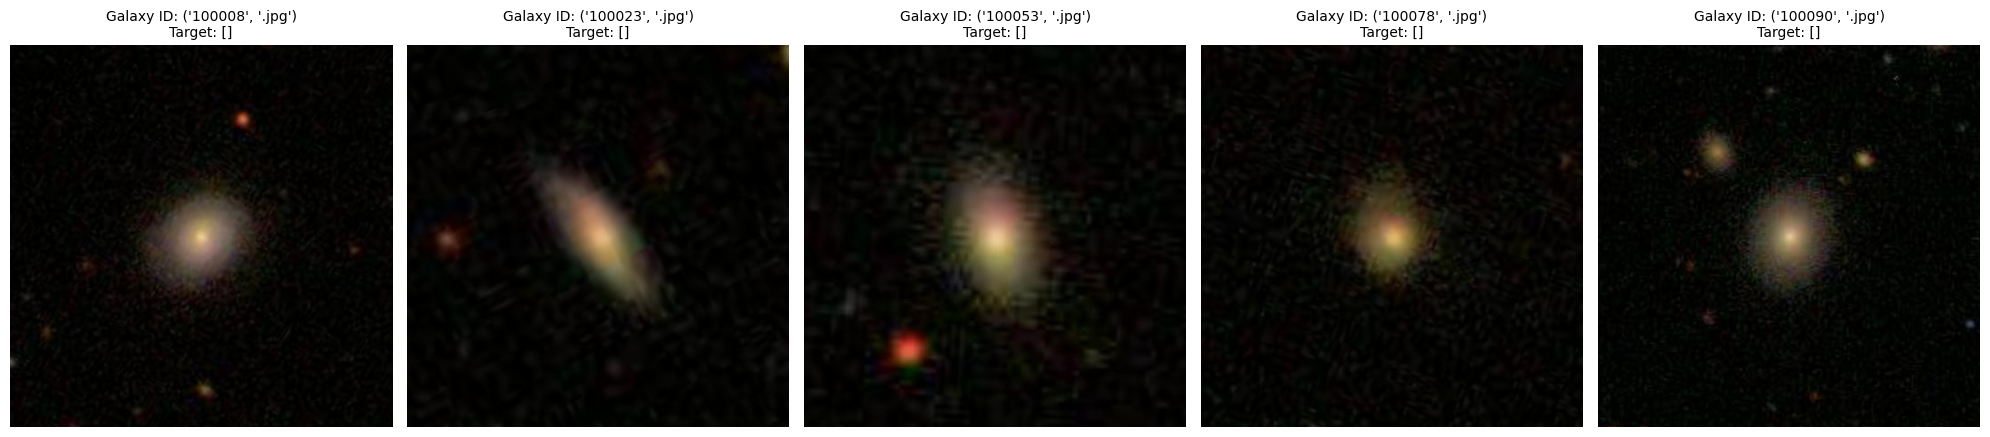

In [24]:
# Visualize first 5 training samples
visualize_samples(train_dataset, num_samples=5)